In [100]:
from tqdm import tqdm
import time
import psutil

import numpy as np
import pandas as pd 

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.algorithms.preprocessing import DisparateImpactRemover

from sklearn.svm import SVC as SVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Display and plot 
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

In [5]:
# Select the model
model_used = "RF"  # SVM, RF

#### Load data

In [129]:
protected = "age"
dataset = load_preproc_data_german([protected])
privileged_groups = [{'age': 1}]
unprivilege_groups = [{'age': 0}]

np.random.seed(42)

#### Visualize

In [130]:
data, dic = dataset.convert_to_dataframe()
df = pd.DataFrame(data)
df

,age,sex,credit_history=Delay,credit_history=None/Paid,credit_history=Other,savings=500+,savings=<500,savings=Unknown/None,employment=1-4 years,employment=4+ years,employment=Unemployed,credit
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
996,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
997,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
998,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0


In [131]:
priv = df.loc[df["age"] == 1.0, "credit"]
unpriv = df.loc[df["age"] == 0.0, "credit"]

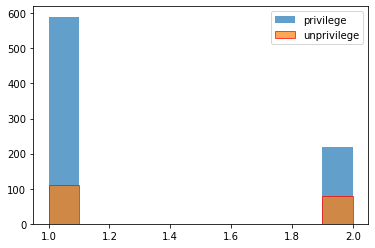

In [132]:
plt.hist(priv, label="privilege", alpha=0.7)
plt.hist(unpriv, label="unprivilege", alpha=0.7, edgecolor='red')
plt.legend()

plt.show()

#### Split train, test

In [133]:
train_set, og_vt_set = dataset.split([0.7], shuffle=True)
og_valid_set, test_set = og_vt_set.split([0.5], shuffle=True)

In [134]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(train_set.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(train_set.favorable_label, train_set.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(train_set.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(train_set.privileged_protected_attributes,
      train_set.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(train_set.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [137]:
if model_used == "SVM":
    scaler = StandardScaler()
    train_set.features = scaler.fit_transform(train_set.features)
    test_set.features = scaler.fit_transform(test_set.features)

index = train_set.feature_names.index(protected)    

### Train, test and Remove DI

In [140]:
di = DisparateImpactRemover(repair_level=0.2)
print(train_set.features)
trans_train_set = di.fit_transform(train_set)
trans_test_set = di.fit_transform(test_set)
print(trans_train_set.features)


ModuleNotFoundError: No module named 'BlackBoxAuditing'

In [ ]:
DIs = []

# try with different repair level
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    # apply DIR to dataset
    trans_train_set = di.fit_transform(train_set)
    trans_test_set = di.fit_transform(test_set)
    
    X_trans = 